In [1]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = None #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'control'

In [4]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [5]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(50,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [6]:
agent.train(env,200,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('UniversalRNN-'+str(condition))

0 0.4895
1 0.49849999999999994
2 0.4983333333333333
3 0.497625
4 0.5013
5 0.5028333333333334
6 0.5049285714285714
7 0.5108125
8 0.5123888888888889
9 0.5176000000000001
10 0.5260499999999999
11 0.5323
12 0.5414500000000001
13 0.5504
14 0.55655
15 0.56315
16 0.5683499999999999
17 0.5737
18 0.5817500000000001
19 0.58375
20 0.5861000000000001
21 0.5882000000000001
22 0.5897499999999999
23 0.59315
24 0.5957
25 0.601
26 0.6053499999999999
27 0.6069000000000001
28 0.6073500000000001
29 0.6128
30 0.6167
31 0.62305
32 0.6266499999999999
33 0.628
34 0.63385
35 0.63755
36 0.6411
37 0.6447499999999999
38 0.6510999999999999
39 0.6535499999999999
40 0.658
41 0.6609
42 0.6644
43 0.6681999999999999
44 0.6710499999999999
45 0.6728000000000001
46 0.67545
47 0.6787000000000001
48 0.67935
49 0.68125
50 0.6822
51 0.6825500000000001
52 0.6847000000000001
53 0.6880499999999999
54 0.6886
55 0.6915
56 0.69415
57 0.6975500000000001
58 0.69965
59 0.7012999999999999
60 0.70355
61 0.7060000000000001
62 0.7071
63 0

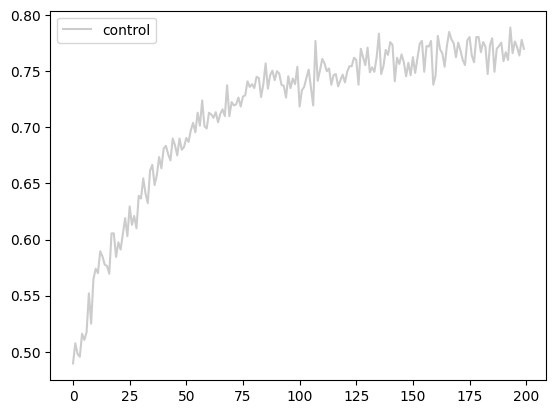

In [7]:
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [5]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(50,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [6]:
agent.load('UniversalRNN-'+str(condition))

LOADING ['nn', 'out_nn']



In [7]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [8]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [9]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [10]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [11]:
out = agent.nn(batch_obs).numpy()
choice = agent.predict(batch_obsf).numpy()

In [12]:
#Residue ref
ref = batch_obsf.get('obs')[:,:,2:].reshape((-1,2))
out = residue(out,ref)

#Residue choice
choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
out = residue(out, choice_batch)

score 0.39060578613491415
score 0.10355190574592249


In [13]:
#fit pca
pca = fit_pca(out.reshape((-1,50)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,50))).reshape(out.shape[:-1]+(nb_variance,))

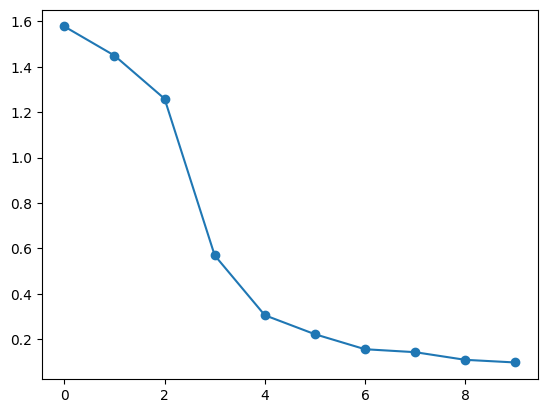

In [14]:
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [15]:
#Plot background function
def plot_bg(pca_batch,zorder=0):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('pca1')
    ax.set_ylabel('pca2')
    ax.set_zlabel('pca3')
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    for i in range(pca_batch.shape[1]):
        ax.scatter(pca_batch[:,i,0],pca_batch[:,i,1],pca_batch[:,i,2],color=colors[i],alpha=0.1,marker='.',zorder=zorder)

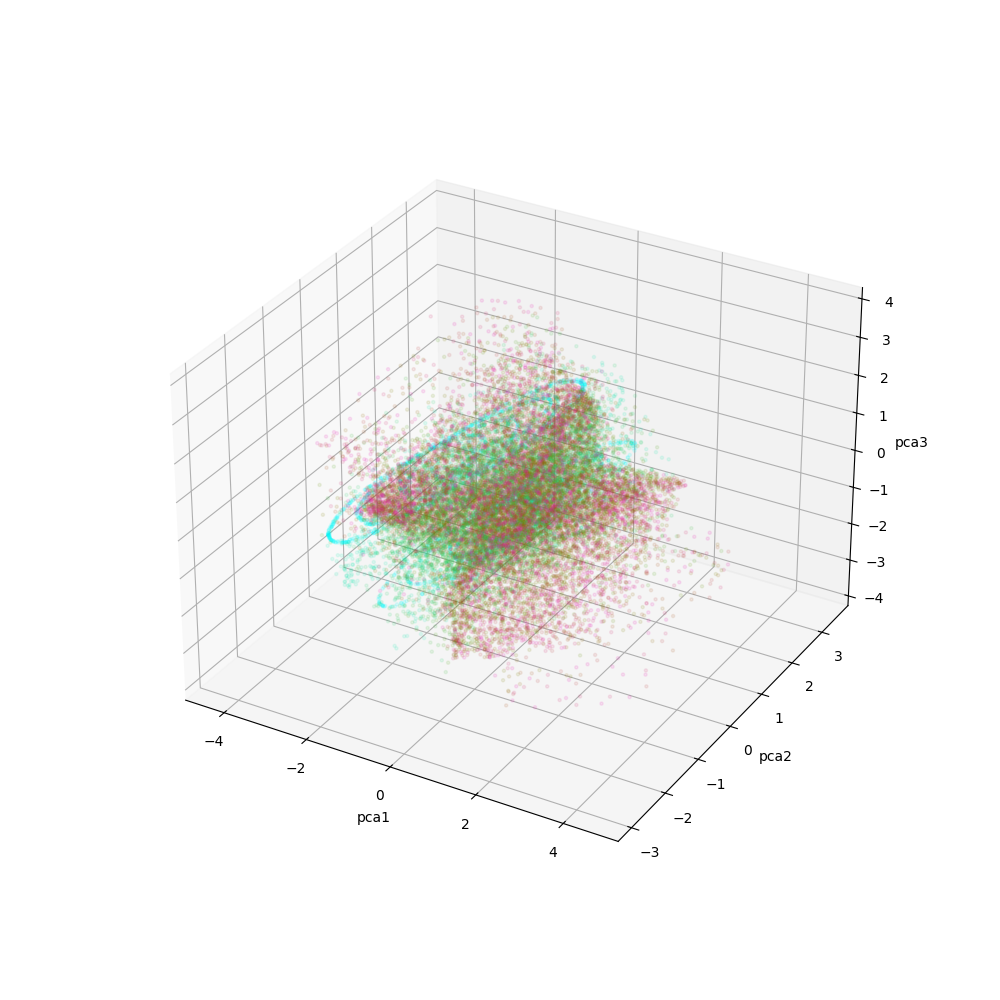

In [26]:
%matplotlib ipympl
from mpl_toolkits import mplot3d
plot_bg(pca_batch)
plt.show()